In [169]:
import warnings
warnings.filterwarnings("ignore")


import pandas as pd
import numpy as np

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_auc_score
from sklearn.metrics import auc as calculate_auc

import matplotlib.pyplot as plt
import seaborn as sns

from aggmap import AggMap, AggModel

np.random.seed(666) #just for reaptable results

def prc_auc_score(y_true, y_score):
    precision, recall, threshold  = precision_recall_curve(y_true, y_score) #PRC_AUC
    auc = calculate_auc(recall, precision)
    return auc

In [170]:
dfx = pd.read_excel('./CRC.xlsx', sheet_name='data')
dfx = dfx[dfx.columns[1:]]
dfx = np.log(dfx + 1e-8)

feature_groups_df = pd.read_excel('./CRC.xlsx', sheet_name='feature_info')
feature_group_list = feature_groups_df.Group.tolist()

dfy_all = pd.read_excel('./CRC.xlsx', sheet_name='sample_info')
dfy = pd.get_dummies(dfy_all['Group'])



X = dfx.values.astype(float)
Y = dfy.values.astype(float)


In [171]:

mp = AggMap(dfx, metric = 'correlation')
mp.fit(cluster_channels = 5, verbose = 0)

mp.fmap_shape

2020-08-19 14:39:24,152 - INFO - [bidd-aggmap] - Calculating distance ...
2020-08-19 14:39:24,192 - INFO - [bidd-aggmap] - the number of process is 16


100%|##########| 849/849 [00:00<00:00, 989.19it/s] 


2020-08-19 14:39:49,430 - INFO - [bidd-aggmap] - applying hierarchical clustering to obtain group information ...
2020-08-19 14:39:52,909 - INFO - [bidd-aggmap] - Applying grid feature map(assignment), this may take several minutes(1~30 min)
2020-08-19 14:39:55,493 - INFO - [bidd-aggmap] - Finished


(30, 29)

## 5 countries to countries cross validation

In [172]:
country_idx = dfy_all.groupby(['Country']).apply(lambda x:x.index.tolist())
country_idx

Country
AUS    [114, 115, 116, 117, 118, 119, 120, 121, 122, ...
CHI    [223, 224, 225, 226, 227, 228, 229, 230, 231, ...
FRA    [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...
GER    [455, 456, 457, 458, 459, 460, 461, 462, 463, ...
USA    [351, 352, 353, 354, 355, 356, 357, 358, 359, ...
dtype: object

In [173]:
country_names = country_idx.index.tolist()

In [174]:
#study to study transfer

run_all = []
for train_country in country_names:

    train_idx = country_idx.loc[train_country]

    trainx = X[train_idx]
    trainY = Y[train_idx]
    trainX = mp.batch_transform(trainx, scale_method = 'standard')        

    clf = AggModel.MultiClassEstimator(epochs = 200,  verbose = 0)
    clf.fit(trainX, trainY)    
    
    for test_country in country_names:
        
        test_idx = country_idx.loc[test_country]
        testY = Y[test_idx]
        testx = X[test_idx]

        testX = mp.batch_transform(testx, scale_method = 'standard')
        print("\n input train and test X shape is %s, %s " % (trainX.shape,  testX.shape))

        y_true = testY[:,0]
        y_pred = clf.predict(testX)[:,0]
        y_score = clf.predict_proba(testX)[:,0]

        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

        acc = (tp + tn) / sum([tn, fp, fn, tp])

        sensitivity = tp / sum([tp, fn])
        specificity = tn / sum([tn, fp])

        prc_auc = prc_auc_score(y_true, y_score)
        roc_auc = roc_auc_score(y_true, y_score)

        precision = tp / sum([tp, fp])
        recall =  tp / sum([tp, fn]) #equals to sensitivity


        res = {'train_country': train_country,
               'test_country':test_country,

               'accuracy':acc, 

               'prc_auc':prc_auc, 
               'roc_auc':roc_auc,

               'sensitivity': sensitivity, 
               'specificity': specificity,

               'precision':precision,
               'recall':recall,
              }

        run_all.append(res)

100%|##########| 109/109 [00:07<00:00, 13.78it/s]


MultiClassEstimator(batch_size=128, conv1_kernel_size=11, dense_avf='relu',
                    dense_layers=[128], epochs=200, lr=0.0001, metric='ROC',
                    monitor='val_loss', name='AggMap MultiClass Estimator',
                    patience=10000, random_state=32, verbose=0)


100%|##########| 109/109 [00:00<00:00, 159.15it/s]



 input train and test X shape is (109, 30, 29, 5), (109, 30, 29, 5) 


100%|##########| 128/128 [00:00<00:00, 181.90it/s]



 input train and test X shape is (109, 30, 29, 5), (128, 30, 29, 5) 


100%|##########| 114/114 [00:00<00:00, 178.31it/s]



 input train and test X shape is (109, 30, 29, 5), (114, 30, 29, 5) 


100%|##########| 120/120 [00:00<00:00, 187.85it/s]



 input train and test X shape is (109, 30, 29, 5), (120, 30, 29, 5) 


100%|##########| 104/104 [00:00<00:00, 214.99it/s]



 input train and test X shape is (109, 30, 29, 5), (104, 30, 29, 5) 


100%|##########| 128/128 [00:00<00:00, 221.37it/s]


MultiClassEstimator(batch_size=128, conv1_kernel_size=11, dense_avf='relu',
                    dense_layers=[128], epochs=200, lr=0.0001, metric='ROC',
                    monitor='val_loss', name='AggMap MultiClass Estimator',
                    patience=10000, random_state=32, verbose=0)


100%|##########| 109/109 [00:00<00:00, 538.39it/s]



 input train and test X shape is (128, 30, 29, 5), (109, 30, 29, 5) 


100%|##########| 128/128 [00:00<00:00, 570.80it/s]



 input train and test X shape is (128, 30, 29, 5), (128, 30, 29, 5) 


100%|##########| 114/114 [00:00<00:00, 463.10it/s]



 input train and test X shape is (128, 30, 29, 5), (114, 30, 29, 5) 


100%|##########| 120/120 [00:00<00:00, 600.47it/s]



 input train and test X shape is (128, 30, 29, 5), (120, 30, 29, 5) 


100%|##########| 104/104 [00:00<00:00, 578.62it/s]



 input train and test X shape is (128, 30, 29, 5), (104, 30, 29, 5) 


100%|##########| 114/114 [00:00<00:00, 722.91it/s]


MultiClassEstimator(batch_size=128, conv1_kernel_size=11, dense_avf='relu',
                    dense_layers=[128], epochs=200, lr=0.0001, metric='ROC',
                    monitor='val_loss', name='AggMap MultiClass Estimator',
                    patience=10000, random_state=32, verbose=0)


100%|##########| 109/109 [00:00<00:00, 234.81it/s]



 input train and test X shape is (114, 30, 29, 5), (109, 30, 29, 5) 


100%|##########| 128/128 [00:00<00:00, 193.87it/s]



 input train and test X shape is (114, 30, 29, 5), (128, 30, 29, 5) 


100%|##########| 114/114 [00:00<00:00, 202.04it/s]



 input train and test X shape is (114, 30, 29, 5), (114, 30, 29, 5) 


100%|##########| 120/120 [00:00<00:00, 169.89it/s]



 input train and test X shape is (114, 30, 29, 5), (120, 30, 29, 5) 


100%|##########| 104/104 [00:00<00:00, 193.78it/s]



 input train and test X shape is (114, 30, 29, 5), (104, 30, 29, 5) 


100%|##########| 120/120 [00:00<00:00, 183.45it/s]


MultiClassEstimator(batch_size=128, conv1_kernel_size=11, dense_avf='relu',
                    dense_layers=[128], epochs=200, lr=0.0001, metric='ROC',
                    monitor='val_loss', name='AggMap MultiClass Estimator',
                    patience=10000, random_state=32, verbose=0)


100%|##########| 109/109 [00:00<00:00, 172.21it/s]



 input train and test X shape is (120, 30, 29, 5), (109, 30, 29, 5) 


100%|##########| 128/128 [00:00<00:00, 216.90it/s]



 input train and test X shape is (120, 30, 29, 5), (128, 30, 29, 5) 


100%|##########| 114/114 [00:00<00:00, 248.83it/s]



 input train and test X shape is (120, 30, 29, 5), (114, 30, 29, 5) 


100%|##########| 120/120 [00:00<00:00, 175.74it/s]



 input train and test X shape is (120, 30, 29, 5), (120, 30, 29, 5) 


100%|##########| 104/104 [00:00<00:00, 187.06it/s]



 input train and test X shape is (120, 30, 29, 5), (104, 30, 29, 5) 


100%|##########| 104/104 [00:00<00:00, 155.63it/s]


MultiClassEstimator(batch_size=128, conv1_kernel_size=11, dense_avf='relu',
                    dense_layers=[128], epochs=200, lr=0.0001, metric='ROC',
                    monitor='val_loss', name='AggMap MultiClass Estimator',
                    patience=10000, random_state=32, verbose=0)


100%|##########| 109/109 [00:00<00:00, 197.58it/s]



 input train and test X shape is (104, 30, 29, 5), (109, 30, 29, 5) 


100%|##########| 128/128 [00:00<00:00, 158.62it/s]



 input train and test X shape is (104, 30, 29, 5), (128, 30, 29, 5) 


100%|##########| 114/114 [00:00<00:00, 186.68it/s]



 input train and test X shape is (104, 30, 29, 5), (114, 30, 29, 5) 


100%|##########| 120/120 [00:00<00:00, 237.24it/s]



 input train and test X shape is (104, 30, 29, 5), (120, 30, 29, 5) 


100%|##########| 104/104 [00:00<00:00, 256.33it/s]



 input train and test X shape is (104, 30, 29, 5), (104, 30, 29, 5) 


In [175]:
clf._model.count_params()

323138

In [200]:
df = pd.DataFrame(run_all)
df.to_csv('./run_all.csv')
df

,train_country,test_country,accuracy,prc_auc,roc_auc,sensitivity,specificity,precision,recall
0,AUS,AUS,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,AUS,CHI,0.656250,0.788183,0.701201,0.635135,0.685185,0.734375,0.635135
2,AUS,FRA,0.640351,0.712288,0.725023,0.641509,0.639344,0.607143,0.641509
3,AUS,GER,0.750000,0.854516,0.827222,0.733333,0.766667,0.758621,0.733333
4,AUS,USA,0.711538,0.794221,0.762944,0.750000,0.673077,0.696429,0.750000
5,CHI,AUS,0.660550,0.739672,0.760524,0.717391,0.619048,0.578947,0.717391
6,CHI,CHI,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
7,CHI,FRA,0.666667,0.744154,0.762140,0.716981,0.622951,0.622951,0.716981
8,CHI,GER,0.783333,0.852679,0.865556,0.700000,0.866667,0.840000,0.700000
9,CHI,USA,0.682692,0.715291,0.730769,0.750000,0.615385,0.661017,0.750000


In [245]:
dfres = pd.crosstab(index = df.train_country, columns= df.test_country, values= df.roc_auc, aggfunc = np.mean)

In [246]:
dfres.to_excel('study2study_results_ROC.xlsx')

In [247]:
cols = ['FRA', 'AUS', 'CHI', 'USA', 'GER']

In [248]:
ourmodel_df = dfres[cols].loc[cols].round(2)
ourmodel_df

test_country,FRA,AUS,CHI,USA,GER
train_country,,,,,
FRA,1.00,0.85,0.82,0.70,0.83
AUS,0.73,1.00,0.70,0.76,0.83
CHI,0.76,0.76,1.00,0.73,0.87
USA,0.66,0.80,0.72,1.00,0.81
GER,0.75,0.77,0.81,0.76,1.00


In [249]:
y = """0.85 0.76 0.82 0.64 0.83
0.62 0.92 0.74 0.59 0.65
0.82 0.76 0.81 0.67 0.83
0.76 0.78 0.70 0.74 0.79
0.84 0.79 0.88 0.74 0.79""" 
# from paper of : Meta-analysis of fecal metagenomes reveals global microbial signatures that are specific for colorectal cancer
previous_df = pd.DataFrame([i.split(' ') for i in y.split('\n')], columns = ourmodel_df.columns, index = ourmodel_df.index).astype(float)
previous_df

test_country,FRA,AUS,CHI,USA,GER
train_country,,,,,
FRA,0.85,0.76,0.82,0.64,0.83
AUS,0.62,0.92,0.74,0.59,0.65
CHI,0.82,0.76,0.81,0.67,0.83
USA,0.76,0.78,0.70,0.74,0.79
GER,0.84,0.79,0.88,0.74,0.79


In [250]:
def get_non_diag_mean(df):
    v = df.values.copy()
    
    np.fill_diagonal(v, np.nan)
    
    mean =  pd.DataFrame(v, columns = df.columns, index = df.index).mean(axis=1).round(2)
    std = pd.DataFrame(v, columns = df.columns, index = df.index).std(axis=1).round(2)
    return mean,std

In [251]:
get_non_diag_mean(previous_df)[0].mean()

0.7500000000000001

In [252]:
get_non_diag_mean(ourmodel_df)[0].mean()

0.772

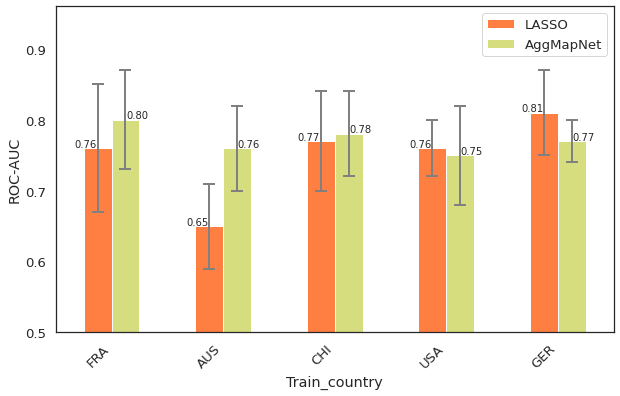

In [330]:
sns.set(style = 'white', font_scale=1.2)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,6), sharex = True, sharey = True)

y1 = get_non_diag_mean(previous_df)[0].to_frame(name = 'LASSO')
y2 = get_non_diag_mean(ourmodel_df)[0].to_frame(name = 'AggMapNet')

y1_err = get_non_diag_mean(previous_df)[1].to_frame(name = 'LASSO')
y2_err = get_non_diag_mean(ourmodel_df)[1].to_frame(name = 'AggMapNet')

y = y1.join(y2)
y_err = y1_err.join(y2_err)

color = sns.color_palette("rainbow_r", 5) #PiYG

y.plot(kind = 'bar',ax = ax, color = color, yerr= y_err,ylim = (0.5, 0.96), error_kw=dict(ecolor='gray', lw=2, capsize=6, capthick=2))
ax.set_ylabel('ROC-AUC')
ax.set_xlabel('Train_country')


for x_, y_ in enumerate(y.LASSO.values):
    ax.annotate('%.2f' % y_, xy = (x_-0.33, y_+0.002), fontsize =10)

for  x_, y_ in enumerate(y.AggMapNet.values):
    ax.annotate('%.2f' % y_, xy = (x_+0.13, y_+0.002), fontsize =10)
    
ax.set_xticklabels(labels = y.index,rotation=45, ha = 'right')

    
fig.savefig('./CRC_performance_comparasion_mean.png', bbox_inches='tight', dpi=300) 

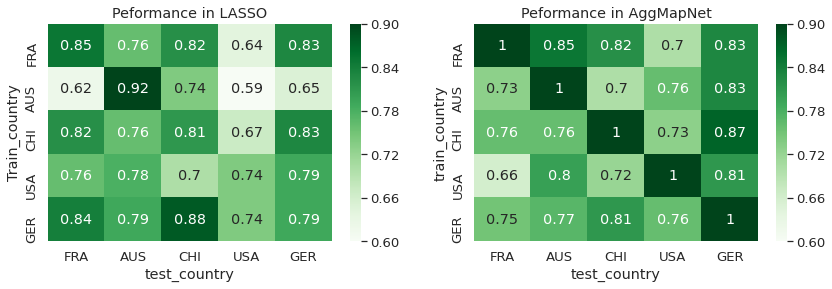

In [300]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,4),)

ax2, ax1 = axes

sns.heatmap( ourmodel_df.round(2), cmap = 'Greens',  ax = ax1, annot=True,  vmin = 0.6, vmax = 0.9)
ax1.set_title("Peformance in AggMapNet")

sns.heatmap(previous_df.round(2), cmap = 'Greens',  ax = ax2, annot=True, vmin = 0.6, vmax = 0.9)
ax2.set_title("Peformance in LASSO")
ax2.set_ylabel('Train_country')


fig.savefig('./CRC_performance_comparasion_all.png', bbox_inches='tight', dpi=300) 